In [ ]:
from parallelrank import findRank
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from timeit import default_timer as timer
from time import sleep

assert len(tf.config.list_physical_devices('GPU')) == 1

In [27]:
# TODO: add tolerance and assert rank difference
tf_rank_computation_seconds = []
parallel_rank_computation_seconds = []
repeats = 10
matrix_sizes = 2 ** np.arange(5, 12)

for matrix_size in matrix_sizes:
    tf_time = 0
    parallel_time = 0
    
    for _ in range(repeats):
        matrix = np.random.random((matrix_size, matrix_size))
        
        tf_start = timer()
        with tf.device('/GPU:0'):
            rank = tf.linalg.matrix_rank(matrix)
        tf_time += timer() - tf_start
        
        parallel_start = timer()
        second_rank = findRank(matrix)
        parallel_time += timer() - parallel_start
    
        assert rank.numpy() == second_rank
        
    tf_rank_computation_seconds.append(tf_time / repeats)
    parallel_rank_computation_seconds.append(parallel_time / repeats)

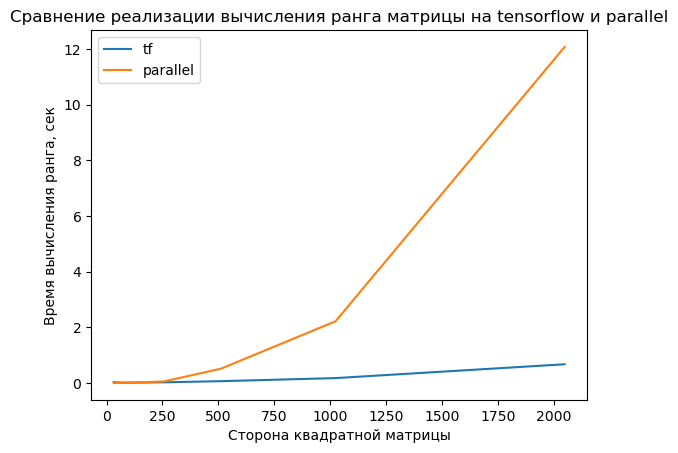

In [31]:
plt.title("Сравнение реализации вычисления ранга матрицы на tensorflow и parallel")
plt.plot(matrix_sizes, tf_rank_computation_seconds, label="tf")
plt.plot(matrix_sizes, parallel_rank_computation_seconds, label="parallel")
plt.legend()
plt.xlabel("Сторона квадратной матрицы")
plt.ylabel("Время вычисления ранга, сек")
plt.show()